In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('/content/drive/MyDrive/csv/BDA/tesla.csv')

# Select relevant columns for the features (X) and target variable (y)
features = df[['Open', 'High', 'Low']]
target = df['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Stage 1 models as a dictionary
models_stage1 = {
    "Linear": LinearRegression(),
    "SVR": SVR(kernel='linear', C=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50, random_state=42)
}

# Fit and evaluate each Stage 1 model
accuracy_scores_stage1 = {}
for model_name, model in models_stage1.items():
    model.fit(X_train, y_train)
    X_train_stage1 = model.predict(X_train).reshape(-1, 1)
    X_test_stage1 = model.predict(X_test).reshape(-1, 1)

    # Train a simple linear regression on the Stage 1 predictions
    linear_stage1 = LinearRegression()
    linear_stage1.fit(X_train_stage1, y_train)
    predictions_stage1 = linear_stage1.predict(X_test_stage1)

    accuracy_scores_stage1[model_name] = linear_stage1.score(X_test_stage1, y_test)

# Select top 3 models based on accuracy from the first stage
top_models_stage1 = sorted(accuracy_scores_stage1.keys(), key=lambda k: accuracy_scores_stage1[k], reverse=True)[:3]

# Create a DataFrame with Stage 1 predictions as features for the selected top model
top_model_stage1_name = top_models_stage1[0]  # Choose the top-performing model
top_model_stage1 = models_stage1[top_model_stage1_name]

# Create a DataFrame with Stage 1 predictions as features for the selected top model
stage1_predictions = pd.DataFrame({
    "Stage1_Predictions": top_model_stage1.predict(X_test).flatten()
})

# Stage 2 models as a dictionary
models_stage2 = {
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Bagging": BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50, random_state=42),
    "ARIMA": ARIMA(y_train, order=(1, 0, 1)).fit(),
    "SARIMA": SARIMAX(y_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit(disp=False)
}

# Fit and evaluate each Stage 2 model using the predictions from Stage 1
accuracy_scores_stage2 = {}
for model_name, model in models_stage2.items():
    stage1_predictions_selected = stage1_predictions["Stage1_Predictions"].values.reshape(-1, 1)

    if model_name in ["ARIMA", "SARIMA"]:
        # Forecast using ARIMA or SARIMA
        arima_forecast = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
        predictions_stage2 = arima_forecast
    else:
        model.fit(stage1_predictions_selected, y_test)
        predictions_stage2 = model.predict(stage1_predictions_selected)

    accuracy_scores_stage2[model_name] = r2_score(y_test, predictions_stage2)

# Select the top-performing model from Stage 2
top_model_stage2_name = max(accuracy_scores_stage2, key=accuracy_scores_stage2.get)
top_model_stage2 = models_stage2[top_model_stage2_name]
# Create a DataFrame with Stage 2 predictions as features for the selected top model
stage2_predictions = pd.DataFrame({
    "Stage2_Predictions": top_model_stage2.predict(stage1_predictions_selected)
})
# Stage 3 models
models_stage3 = [
    ("DNN", MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)),
    ("LSTM", Sequential([LSTM(50, activation='relu', input_shape=(1, 1)),
                         Dense(1)])),
    ("RNN", Sequential([SimpleRNN(50, activation='relu', input_shape=(1, 1)),
                        Dense(1)]))
]

# Preprocess the data for neural network models
X_train_nn = stage2_predictions.values.reshape(-1, 1, 1)
y_train_nn = y_test.values.reshape(-1, 1)

# Fit and evaluate each Stage 3 model using the predictions from Stage 2
accuracy_scores_stage3 = {}
for model_name, model in models_stage3:
    if model_name == "DNN":
        model.fit(stage2_predictions, y_test)
        predictions_stage3 = model.predict(stage2_predictions)
    else:
        # Assume you have a separate function for building and compiling the Keras model
        def build_model():
            model = Sequential([SimpleRNN(50, activation='relu', input_shape=(1, 1)),
                                Dense(1)])
            model.compile(optimizer='adam', loss='mean_squared_error')
            return model

        keras_model = build_model()
        keras_model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, verbose=0)
        predictions_stage3 = keras_model.predict(X_train_nn).reshape(-1, 1)

    accuracy_scores_stage3[model_name] = r2_score(y_test, predictions_stage3)

# Print the accuracy from the third stage for each model
max_accuracy_model = max(accuracy_scores_stage3, key=accuracy_scores_stage3.get)
max_accuracy_value = accuracy_scores_stage3[max_accuracy_model]

print(f"\nModel with the maximum accuracy in the 3rd stage: {max_accuracy_model}")
print(f"Maximum accuracy value: {max_accuracy_value}")



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-sta

14/14 [==============================] - 0s 2ms/step

Model with the maximum accuracy in the 3rd stage: DNN
Maximum accuracy value: 0.9998933860816032


In [5]:
# Evaluation metrics for the final model
final_predictions = predictions_stage3  # Use the predictions from the third stage

# R2 Score
final_r2 = r2_score(y_test, predictions_stage3)
print("\nFinal R2 Score on the Entire Model:", final_r2)

# Mean Squared Error (MSE)
final_mse = mean_squared_error(y_test, final_predictions)
print("Final Mean Squared Error on the Entire Model:", final_mse)

# Mean Absolute Error (MAE)
final_mae = mean_absolute_error(y_test, final_predictions)
print("Final Mean Absolute Error on the Entire Model:", final_mae)

# Median Absolute Error (MedAE)
final_medae = median_absolute_error(y_test, final_predictions)
print("Final Median Absolute Error on the Entire Model:", final_medae)

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

final_mape = mean_absolute_percentage_error(y_test, final_predictions)
print("Final Mean Absolute Percentage Error on the Entire Model:", final_mape)


Final R2 Score on the Entire Model: 0.8038916300932147
Final Mean Squared Error on the Entire Model: 2612.5636741634753
Final Mean Absolute Error on the Entire Model: 42.26614117447615
Final Median Absolute Error on the Entire Model: 49.981873051757816


ValueError: Data must be 1-dimensional

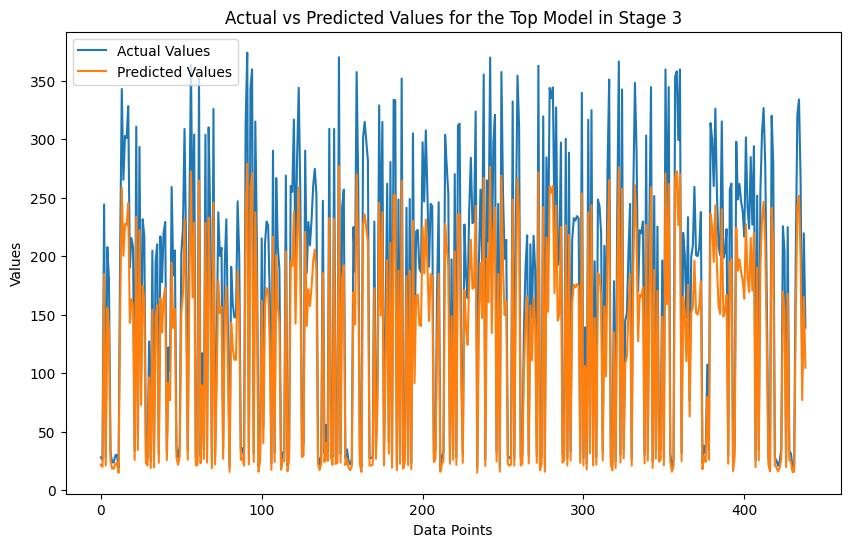

In [6]:
# Plot actual vs predicted values for the top model in Stage 3
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Values')
plt.plot(predictions_stage3, label='Predicted Values')
plt.title('Actual vs Predicted Values for the Top Model in Stage 3')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()
plt.show()

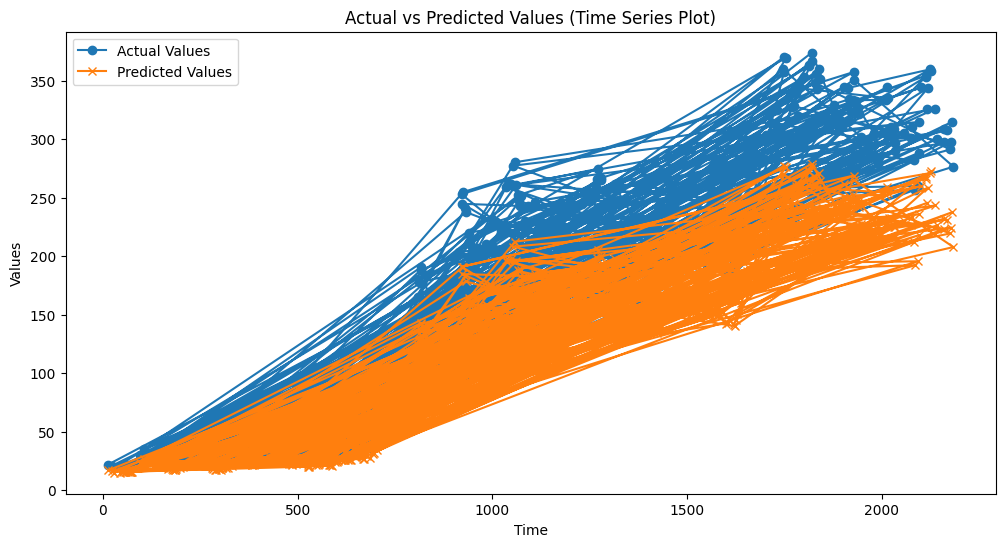

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Values', marker='o')
plt.plot(y_test.index, predictions_stage3.flatten(), label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values (Time Series Plot)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


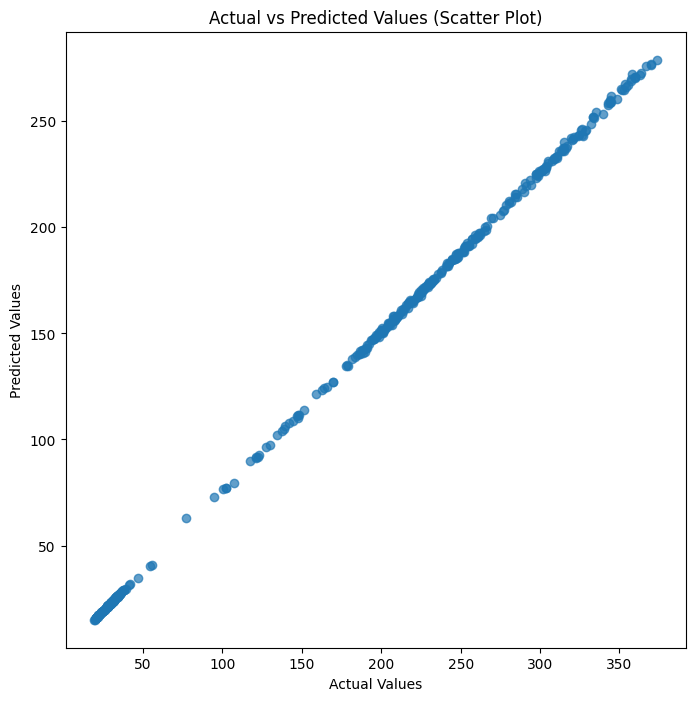

In [8]:

# Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions_stage3.flatten(), alpha=0.7)
plt.title('Actual vs Predicted Values (Scatter Plot)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


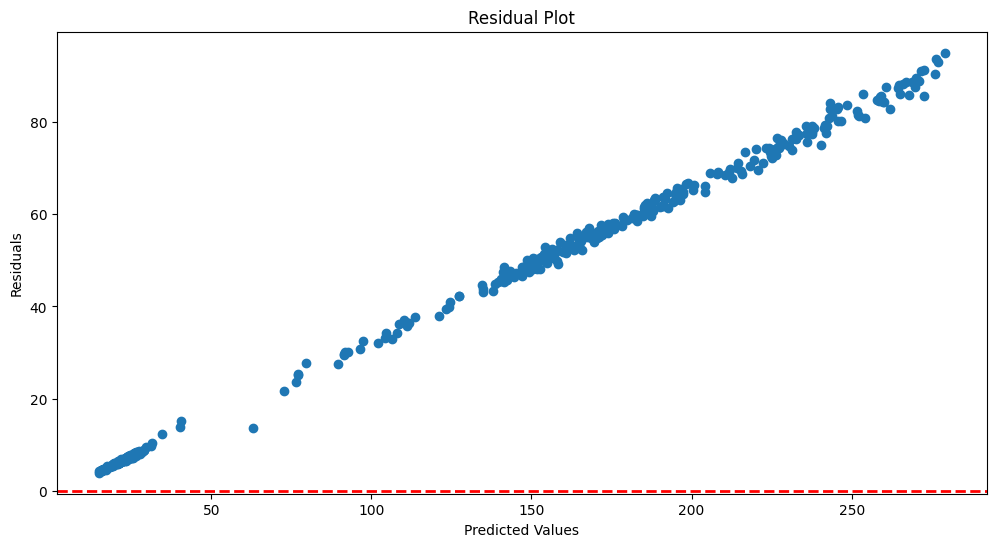

In [9]:

# Residual Plot
plt.figure(figsize=(12, 6))
residuals = y_test.values - predictions_stage3.flatten()
plt.scatter(predictions_stage3.flatten(), residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()



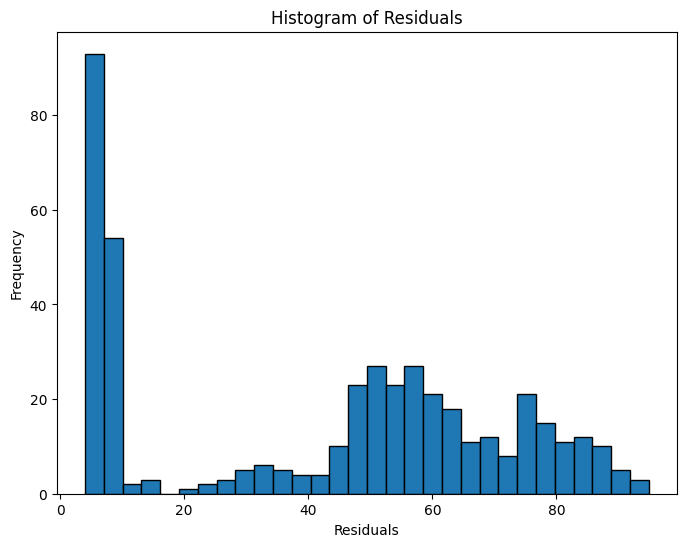

In [10]:
# Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [11]:
# Find the top-performing model from Stage 3
top_model_stage3_name = max(accuracy_scores_stage3, key=accuracy_scores_stage3.get)
top_model_stage3_index = [name for name, _ in models_stage3].index(top_model_stage3_name)
top_model_stage3 = models_stage3[top_model_stage3_index][1]

# Print the details of the top-performing model
print("\nTop-performing model from Stage 3:")
print(f"Model: {type(top_model_stage3).__name__}")
print(f"Accuracy: {accuracy_scores_stage3[top_model_stage3_name]}")

# Now, you can use 'top_model_stage3' for further analysis or predictions.



Top-performing model from Stage 3:
Model: MLPRegressor
Accuracy: 0.9998933860816032


In [13]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.7 MB/s eta 0:00:00


In [26]:
import shap
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Assuming `keras_model` is the trained Keras model in the last stage
keras_model = build_model()  # Use your function to build and train the Keras model

# Assuming `X_train_nn` is the preprocessed data for neural network models
X_train_nn = stage2_predictions.values.reshape(-1, 1, 1)

# Train the Keras model
keras_model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, verbose=0)

# Convert the Keras model into a callable function
def keras_model_predict(x):
    return keras_model.predict(x.reshape(-1, 1, 1)).flatten()

# Sample 100 background data points
background_data = shap.sample(X_train_nn.reshape(X_train_nn.shape[0], -1), 100)

# Ensure that the background_data has the same number of features as the model input
background_data = background_data[:, :X_train_nn.shape[1]]

# Check the shape of X_test before reshaping
print(X_test.shape)

# Reshape X_test
num_samples = X_test.shape[0]
X_test_reshaped = X_test.values.reshape(num_samples, -1, 1)

# Check the shape of X_test after reshaping
print(X_test_reshaped.shape)

# Create the explainer using the sampled background data
explainer = shap.KernelExplainer(keras_model_predict, background_data)

# Get SHAP values for test data
shap_values = explainer.shap_values(X_test_reshaped[0])  # Use the first sample for now

# Reshape shap_values based on the original shape of the data
shap_values_reshaped = shap_values[0].reshape(1, -1, 1)

# Summary plot => not working!!
#shap.summary_plot(shap_values_reshaped[0], X_test_reshaped[0])  # Adjust index as needed


(439, 3)
(439, 3, 1)
4/4 [==============================] - 0s 5ms/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


In [28]:
pip install PySpark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PySpark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=0c2440aae006a20cd98f94103ca0a40ae18247473baf2f18d6e89d6ce4e8f63f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built PySpark


In [42]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize Spark session
spark = SparkSession.builder.appName("TeslaStockPrediction").getOrCreate()

# Load data into a PySpark DataFrame
df = spark.read.csv("/content/drive/MyDrive/csv/BDA/tesla.csv", header=True, inferSchema=True)

# Select relevant columns for the features (X) and target variable (y)
feature_cols = ['Open', 'High', 'Low']
target_col = 'Close'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Stage 1 models
lr = LinearRegression(featuresCol="features", labelCol=target_col)
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, numTrees=100)
gbt = GBTRegressor(featuresCol="features", labelCol=target_col, maxIter=100)

# Fit and evaluate each Stage 1 model
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
gbt_model = gbt.fit(train_data)

# Transform the test data and alias the prediction columns
lr_predictions = lr_model.transform(test_data).selectExpr("prediction as lr_prediction", "features")
rf_predictions = rf_model.transform(test_data).selectExpr("prediction as rf_prediction", "features")
gbt_predictions = gbt_model.transform(test_data).selectExpr("prediction as gbt_prediction", "features")

# Join the predictions
stage1_predictions = lr_predictions.join(rf_predictions.alias("rf_pred"), on="features").join(gbt_predictions.alias("gbt_pred"), on="features")


# Generate Stage 2 predictions
arima_model = ARIMA(df.select(target_col).rdd.map(lambda x: x[0]).collect(), order=(1, 0, 1)).fit()
sarima_model = SARIMAX(df.select(target_col).rdd.map(lambda x: x[0]).collect(), order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()

# Select relevant columns from the joined DataFrames
selected_columns = ["lr_prediction", "rf_prediction", "gbt_prediction", "features"]
stage1_predictions = lr_predictions.join(rf_predictions.alias("rf_pred"), on="features") \
                                    .join(gbt_predictions.alias("gbt_pred"), on="features") \
                                    .select(selected_columns)

# Convert to Pandas DataFrame
stage1_predictions_pandas = stage1_predictions.toPandas()

# Generate Stage 2 predictions

# Generate Stage 2 predictions
# Assuming arima_model is already fitted
num_test_data = test_data.count()  # Extract the number of rows in the test_data DataFrame
end_index = train_data.count() + num_test_data - 1
arima_forecast = arima_model.get_forecast(steps=num_test_data).predicted_mean

# Access the forecast for the test period
start_index = end_index - num_test_data + 1
end_index = end_index + 1  # Include the end index in the slice
stage2_predictions_arima = arima_forecast[start_index:end_index]


# Assuming sarima_model is already fitted
num_test_data = test_data.count()  # Extract the number of rows in the test_data DataFrame
start_index_sarima = train_data.count()  # Start index for SARIMA forecast
end_index_sarima = start_index_sarima + num_test_data - 1  # End index for SARIMA forecast

# Generate Stage 2 predictions for SARIMA
#stage2_predictions_sarima = sarima_model.get_forecast(steps=num_test_data).predicted_mean


# Stage 3 models
# Note: PySpark does not have direct equivalents for DNN, LSTM, SimpleRNN. You might use MLlib for simpler models.
# For deep learning models, consider using other frameworks like TensorFlow or PyTorch.

# Stop the Spark session
spark.stop()


Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
